# Running TARDIS with a custom packet source

In [1]:
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.montecarlo.packet_source import BasePacketSource
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

/usr/share/miniconda/envs/tardis/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
download_atom_data('kurucz_cd23_chianti_H_He')

[tardis.io.config_internal][WARNING]  Configuration File /home/vsts/.astropy/config/tardis_internal_config.yml does not exist - creating new one from default (config_internal.py:16)


CRITICAL:root:
********************************************************************************

TARDIS will download different kinds of data (e.g. atomic) to its data directory /home/vsts/Downloads/tardis-data

TARDIS DATA DIRECTORY not specified in /home/vsts/.astropy/config/tardis_internal_config.yml:

ASSUMING DEFAULT DATA DIRECTORY /home/vsts/Downloads/tardis-data
 YOU CAN CHANGE THIS AT ANY TIME IN /home/vsts/.astropy/config/tardis_internal_config.yml 

******************************************************************************** 




[tardis.io.atom_data.atom_web_download][INFO   ]  Downloading atomic data from https://media.githubusercontent.com/media/tardis-sn/tardis-refdata/master/atom_data/kurucz_cd23_chianti_H_He.h5 to /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (atom_web_download.py:47)


INFO:tardis.io.atom_data.atom_web_download:Downloading atomic data from https://media.githubusercontent.com/media/tardis-sn/tardis-refdata/master/atom_data/kurucz_cd23_chianti_H_He.h5 to /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5


Custom packet source class that is derived from BasePacketSource. The method create_packets (which returns ```nus, mus, energies```) has to be defined.

In [3]:
class TruncBlackbodySource(BasePacketSource):
    """
        Custom inner boundary source class to replace the Blackbody source
        with a truncated Blackbody source.
    """
    
    def __init__(self, seed, truncation_wavelength):
        super().__init__(seed)
        self.truncation_wavelength = truncation_wavelength
    
    def create_packets(self, T, no_of_packets,
                       drawing_sample_size=None):
        """
        Packet source that generates a truncated Blackbody source.
        
        Parameters
        ----------
        T : float
            Blackbody temperature
        no_of_packets : int
            number of packets to be created
        truncation_wavelength : float
            truncation wavelength in Angstrom. 
            Only wavelengths higher than the truncation wavelength
            will be sampled.
        """
        
        
        # Use mus and energies from normal blackbody source.
        mus = self.create_zero_limb_darkening_packet_mus(no_of_packets)
        energies = self.create_uniform_packet_energies(no_of_packets)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = u.Quantity(self.truncation_wavelength, u.Angstrom).to(
                                          u.Hz, equivalencies=u.spectral()).value
        
        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_blackbody_packet_nus(T, drawing_sample_size)
        nus = nus[nus<truncation_frequency][:no_of_packets]
        
        
        # Only required if the truncation wavelength is too big compared to the maximum 
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_blackbody_packet_nus(
                T, drawing_sample_size
            )
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]
            
        return nus, mus, energies

In [4]:
packet_source = TruncBlackbodySource(
    53253, truncation_wavelength=2000
)

In [5]:
mdl = run_tardis('tardis_example.yml',
                 packet_source=packet_source)
mdl_norm = run_tardis('tardis_example.yml')

[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:74)


INFO:tardis.plasma.standard_plasmas:Reading Atomic Data from kurucz_cd23_chianti_H_He.h5


[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:29)


INFO:tardis.io.atom_data.util:Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5


[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:184)


INFO:tardis.io.atom_data.base:Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace.


[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data (base.py:187)


INFO:tardis.io.atom_data.base:Non provided atomic data: synpp_refs, photoionization_data


[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 1/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.02608e+42 erg / s Luminosity absorbed = 2.58369e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.02608e+42 erg / s Luminosity absorbed = 2.58369e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9926.501965  9338.157295  0.400392  0.702876
	5      9852.611678  9612.552655  0.211205  0.251645
	10     9779.813302  9582.236692  0.142695  0.147553
	15     9708.082813  9347.739573  0.104556  0.108727

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9926.501965  9338.157295  0.400392  0.702876
	5      9852.611678  9612.552655  0.211205  0.251645
	10     9779.813302  9582.236692  0.142695  0.147553
	15     9708.082813  9347.739573  0.104556  0.108727




[tardis.simulation.base][INFO   ]  t_inner 9933.952 K -- next t_inner 11412.349 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9933.952 K -- next t_inner 11412.349 K


[tardis.simulation.base][INFO   ]  Starting iteration 2/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 2/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.39291e+43 erg / s Luminosity absorbed = 4.54291e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.39291e+43 erg / s Luminosity absorbed = 4.54291e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9338.157295   9894.977618  0.702876  0.966539
	5      9612.552655  10202.697494  0.251645  0.345750
	10     9582.236692  10182.708604  0.147553  0.203029
	15     9347.739573   9966.709240  0.108727  0.147105

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9338.157295   9894.977618  0.702876  0.966539
	5      9612.552655  10202.697494  0.251645  0.345750
	10     9582.236692  10182.708604  0.147553  0.203029
	15     9347.739573   9966.709240  0.108727  0.147105




[tardis.simulation.base][INFO   ]  t_inner 11412.349 K -- next t_inner 9952.175 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11412.349 K -- next t_inner 9952.175 K


[tardis.simulation.base][INFO   ]  Starting iteration 3/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 3/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.15076e+42 erg / s Luminosity absorbed = 2.54247e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.15076e+42 erg / s Luminosity absorbed = 2.54247e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9894.977618  9365.300413  0.966539  0.691893
	5      10202.697494  9687.991731  0.345750  0.246499
	10     10182.708604  9558.583356  0.203029  0.150936
	15      9966.709240  9323.776228  0.147105  0.111587

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9894.977618  9365.300413  0.966539  0.691893
	5      10202.697494  9687.991731  0.345750  0.246499
	10     10182.708604  9558.583356  0.203029  0.150936
	15      9966.709240  9323.776228  0.147105  0.111587




[tardis.simulation.base][INFO   ]  t_inner 9952.175 K -- next t_inner 11345.501 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9952.175 K -- next t_inner 11345.501 K


[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 4/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.36105e+43 erg / s Luminosity absorbed = 4.43259e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.36105e+43 erg / s Luminosity absorbed = 4.43259e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9365.300413   9907.030060  0.691893  0.940840
	5      9687.991731  10157.363473  0.246499  0.348819
	10     9558.583356  10060.340925  0.150936  0.207129
	15     9323.776228   9871.609020  0.111587  0.148903

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9365.300413   9907.030060  0.691893  0.940840
	5      9687.991731  10157.363473  0.246499  0.348819
	10     9558.583356  10060.340925  0.150936  0.207129
	15     9323.776228   9871.609020  0.111587  0.148903




[tardis.simulation.base][INFO   ]  t_inner 11345.501 K -- next t_inner 10009.025 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11345.501 K -- next t_inner 10009.025 K


[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 5/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.30272e+42 erg / s Luminosity absorbed = 2.63244e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.30272e+42 erg / s Luminosity absorbed = 2.63244e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9907.030060  9360.662190  0.940840  0.714939
	5      10157.363473  9665.421084  0.348819  0.253723
	10     10060.340925  9591.474063  0.207129  0.153326
	15      9871.609020  9334.785438  0.148903  0.113393

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9907.030060  9360.662190  0.940840  0.714939
	5      10157.363473  9665.421084  0.348819  0.253723
	10     10060.340925  9591.474063  0.207129  0.153326
	15      9871.609020  9334.785438  0.148903  0.113393




[tardis.simulation.base][INFO   ]  t_inner 10009.025 K -- next t_inner 11305.404 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10009.025 K -- next t_inner 11305.404 K


[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 6/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.34104e+43 erg / s Luminosity absorbed = 4.37610e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.34104e+43 erg / s Luminosity absorbed = 4.37610e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9360.662190   9876.738275  0.714939  0.941170
	5      9665.421084  10154.492596  0.253723  0.342581
	10     9591.474063  10115.366542  0.153326  0.201794
	15     9334.785438   9911.072182  0.113393  0.144362

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9360.662190   9876.738275  0.714939  0.941170
	5      9665.421084  10154.492596  0.253723  0.342581
	10     9591.474063  10115.366542  0.153326  0.201794
	15     9334.785438   9911.072182  0.113393  0.144362




[tardis.simulation.base][INFO   ]  t_inner 11305.404 K -- next t_inner 10047.761 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11305.404 K -- next t_inner 10047.761 K


[tardis.simulation.base][INFO   ]  Starting iteration 7/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 7/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.44193e+42 erg / s Luminosity absorbed = 2.66459e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.44193e+42 erg / s Luminosity absorbed = 2.66459e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9876.738275  9357.637970  0.941170  0.724592
	5      10154.492596  9604.319160  0.342581  0.264155
	10     10115.366542  9615.353499  0.201794  0.154099
	15      9911.072182  9327.253942  0.144362  0.115690

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9876.738275  9357.637970  0.941170  0.724592
	5      10154.492596  9604.319160  0.342581  0.264155
	10     10115.366542  9615.353499  0.201794  0.154099
	15      9911.072182  9327.253942  0.144362  0.115690




[tardis.simulation.base][INFO   ]  t_inner 10047.761 K -- next t_inner 11255.198 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10047.761 K -- next t_inner 11255.198 K


[tardis.simulation.base][INFO   ]  Starting iteration 8/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 8/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.31896e+43 erg / s Luminosity absorbed = 4.28538e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.31896e+43 erg / s Luminosity absorbed = 4.28538e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9357.637970   9861.424853  0.724592  0.930204
	5      9604.319160  10099.742489  0.264155  0.344092
	10     9615.353499  10090.518152  0.154099  0.200887
	15     9327.253942   9870.608513  0.115690  0.144606

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9357.637970   9861.424853  0.724592  0.930204
	5      9604.319160  10099.742489  0.264155  0.344092
	10     9615.353499  10090.518152  0.154099  0.200887
	15     9327.253942   9870.608513  0.115690  0.144606




[tardis.simulation.base][INFO   ]  t_inner 11255.198 K -- next t_inner 10086.550 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11255.198 K -- next t_inner 10086.550 K


[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 9/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.60733e+42 erg / s Luminosity absorbed = 2.67348e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.60733e+42 erg / s Luminosity absorbed = 2.67348e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9861.424853  9405.531806  0.930204  0.720048
	5      10099.742489  9706.868088  0.344092  0.258230
	10     10090.518152  9581.041021  0.200887  0.158277
	15      9870.608513  9374.894038  0.144606  0.115272

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9861.424853  9405.531806  0.930204  0.720048
	5      10099.742489  9706.868088  0.344092  0.258230
	10     10090.518152  9581.041021  0.200887  0.158277
	15      9870.608513  9374.894038  0.144606  0.115272




[tardis.simulation.base][INFO   ]  t_inner 10086.550 K -- next t_inner 11189.559 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10086.550 K -- next t_inner 11189.559 K


[tardis.simulation.base][INFO   ]  Starting iteration 10/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 10/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.28357e+43 erg / s Luminosity absorbed = 4.23057e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.28357e+43 erg / s Luminosity absorbed = 4.23057e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9405.531806   9939.135057  0.720048  0.883124
	5      9706.868088  10158.167298  0.258230  0.327686
	10     9581.041021  10118.893837  0.158277  0.191491
	15     9374.894038   9923.593783  0.115272  0.138466

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9405.531806   9939.135057  0.720048  0.883124
	5      9706.868088  10158.167298  0.258230  0.327686
	10     9581.041021  10118.893837  0.158277  0.191491
	15     9374.894038   9923.593783  0.115272  0.138466




[tardis.simulation.base][INFO   ]  t_inner 11189.559 K -- next t_inner 10164.998 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11189.559 K -- next t_inner 10164.998 K


[tardis.simulation.base][INFO   ]  Starting iteration 11/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 11/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.84954e+42 erg / s Luminosity absorbed = 2.78548e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.84954e+42 erg / s Luminosity absorbed = 2.78548e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9939.135057  9484.739802  0.883124  0.720538
	5      10158.167298  9706.177432  0.327686  0.265179
	10     10118.893837  9617.358094  0.191491  0.160158
	15      9923.593783  9457.726164  0.138466  0.115525

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9939.135057  9484.739802  0.883124  0.720538
	5      10158.167298  9706.177432  0.327686  0.265179
	10     10118.893837  9617.358094  0.191491  0.160158
	15      9923.593783  9457.726164  0.138466  0.115525




[tardis.simulation.base][INFO   ]  t_inner 10164.998 K -- next t_inner 11121.199 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10164.998 K -- next t_inner 11121.199 K


[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 12/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.25251e+43 erg / s Luminosity absorbed = 4.13304e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.25251e+43 erg / s Luminosity absorbed = 4.13304e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9484.739802   9841.925614  0.720538  0.902204
	5      9706.177432  10092.504495  0.265179  0.324445
	10     9617.358094  10052.135197  0.160158  0.192410
	15     9457.726164   9782.630710  0.115525  0.141517

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9484.739802   9841.925614  0.720538  0.902204
	5      9706.177432  10092.504495  0.265179  0.324445
	10     9617.358094  10052.135197  0.160158  0.192410
	15     9457.726164   9782.630710  0.115525  0.141517




[tardis.simulation.base][INFO   ]  t_inner 11121.199 K -- next t_inner 10227.427 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11121.199 K -- next t_inner 10227.427 K


[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 13/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.05458e+42 erg / s Luminosity absorbed = 2.86723e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.05458e+42 erg / s Luminosity absorbed = 2.86723e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9841.925614  9443.902372  0.902204  0.749187
	5      10092.504495  9786.461495  0.324445  0.262930
	10     10052.135197  9697.013069  0.192410  0.158719
	15      9782.630710  9432.702063  0.141517  0.119159

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9841.925614  9443.902372  0.902204  0.749187
	5      10092.504495  9786.461495  0.324445  0.262930
	10     10052.135197  9697.013069  0.192410  0.158719
	15      9782.630710  9432.702063  0.141517  0.119159




[tardis.simulation.base][INFO   ]  t_inner 10227.427 K -- next t_inner 11062.081 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10227.427 K -- next t_inner 11062.081 K


[tardis.simulation.base][INFO   ]  Starting iteration 14/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 14/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.22773e+43 erg / s Luminosity absorbed = 4.02550e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.22773e+43 erg / s Luminosity absorbed = 4.02550e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9443.902372   9826.363638  0.749187  0.880749
	5      9786.461495  10099.573803  0.262930  0.322389
	10     9697.013069  10000.735484  0.158719  0.193070
	15     9432.702063   9775.253155  0.119159  0.140204

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9443.902372   9826.363638  0.749187  0.880749
	5      9786.461495  10099.573803  0.262930  0.322389
	10     9697.013069  10000.735484  0.158719  0.193070
	15     9432.702063   9775.253155  0.119159  0.140204




[tardis.simulation.base][INFO   ]  t_inner 11062.081 K -- next t_inner 10275.183 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11062.081 K -- next t_inner 10275.183 K


[tardis.simulation.base][INFO   ]  Starting iteration 15/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 15/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.23679e+42 erg / s Luminosity absorbed = 2.90948e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.23679e+42 erg / s Luminosity absorbed = 2.90948e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9826.363638  9471.835438  0.880749  0.752232
	5      10099.573803  9774.926635  0.322389  0.269708
	10     10000.735484  9736.476310  0.193070  0.160718
	15      9775.253155  9529.135535  0.140204  0.116771

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9826.363638  9471.835438  0.880749  0.752232
	5      10099.573803  9774.926635  0.322389  0.269708
	10     10000.735484  9736.476310  0.193070  0.160718
	15      9775.253155  9529.135535  0.140204  0.116771




[tardis.simulation.base][INFO   ]  t_inner 10275.183 K -- next t_inner 11003.572 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10275.183 K -- next t_inner 11003.572 K


[tardis.simulation.base][INFO   ]  Starting iteration 16/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 16/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.20018e+43 erg / s Luminosity absorbed = 3.96167e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.20018e+43 erg / s Luminosity absorbed = 3.96167e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9471.835438   9746.841643  0.752232  0.891990
	5      9774.926635  10040.506275  0.269708  0.318153
	10     9736.476310  10035.407919  0.160718  0.185537
	15     9529.135535   9778.254325  0.116771  0.136998

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9471.835438   9746.841643  0.752232  0.891990
	5      9774.926635  10040.506275  0.269708  0.318153
	10     9736.476310  10035.407919  0.160718  0.185537
	15     9529.135535   9778.254325  0.116771  0.136998




[tardis.simulation.base][INFO   ]  t_inner 11003.572 K -- next t_inner 10337.480 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11003.572 K -- next t_inner 10337.480 K


[tardis.simulation.base][INFO   ]  Starting iteration 17/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 17/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.42545e+42 erg / s Luminosity absorbed = 3.01444e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.42545e+42 erg / s Luminosity absorbed = 3.01444e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9746.841643  9517.502610  0.891990  0.763386
	5      10040.506275  9754.535583  0.318153  0.280468
	10     10035.407919  9733.778355  0.185537  0.164267
	15      9778.254325  9499.088283  0.136998  0.120797

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad   next_t_rad         w    next_w
	Shell                                               
	0       9746.841643  9517.502610  0.891990  0.763386
	5      10040.506275  9754.535583  0.318153  0.280468
	10     10035.407919  9733.778355  0.185537  0.164267
	15      9778.254325  9499.088283  0.136998  0.120797




[tardis.simulation.base][INFO   ]  t_inner 10337.480 K -- next t_inner 10958.934 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10337.480 K -- next t_inner 10958.934 K


[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 18/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.17856e+43 erg / s Luminosity absorbed = 3.92120e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.17856e+43 erg / s Luminosity absorbed = 3.92120e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9517.502610  9747.776877  0.763386  0.874021
	5      9754.535583  9950.736226  0.280468  0.323624
	10     9733.778355  9887.229139  0.164267  0.192196
	15     9499.088283  9698.956311  0.120797  0.138246

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9517.502610  9747.776877  0.763386  0.874021
	5      9754.535583  9950.736226  0.280468  0.323624
	10     9733.778355  9887.229139  0.164267  0.192196
	15     9499.088283  9698.956311  0.120797  0.138246




[tardis.simulation.base][INFO   ]  t_inner 10958.934 K -- next t_inner 10389.554 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10958.934 K -- next t_inner 10389.554 K


[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 19/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.62056e+42 erg / s Luminosity absorbed = 3.06969e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.62056e+42 erg / s Luminosity absorbed = 3.06969e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9747.776877  9500.052787  0.874021  0.783088
	5      9950.736226  9783.184930  0.323624  0.283790
	10     9887.229139  9678.941562  0.192196  0.171831
	15     9698.956311  9506.074332  0.138246  0.122892

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad   next_t_rad         w    next_w
	Shell                                              
	0      9747.776877  9500.052787  0.874021  0.783088
	5      9950.736226  9783.184930  0.323624  0.283790
	10     9887.229139  9678.941562  0.192196  0.171831
	15     9698.956311  9506.074332  0.138246  0.122892




[tardis.simulation.base][INFO   ]  t_inner 10389.554 K -- next t_inner 10901.882 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10389.554 K -- next t_inner 10901.882 K


[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 20/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.16177e+43 erg / s Luminosity absorbed = 3.76611e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.16177e+43 erg / s Luminosity absorbed = 3.76611e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Simulation finished in 20 iterations and took 38.79 s (base.py:308)


INFO:tardis.simulation.base:Simulation finished in 20 iterations and took 38.79 s


[tardis.plasma.standard_plasmas][INFO   ]  Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:74)


INFO:tardis.plasma.standard_plasmas:Reading Atomic Data from kurucz_cd23_chianti_H_He.h5


[tardis.io.atom_data.util][INFO   ]  Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:29)


INFO:tardis.io.atom_data.util:Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path. Exists in TARDIS Data repo /home/vsts/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5


[tardis.io.atom_data.base][INFO   ]  Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace. (base.py:184)


INFO:tardis.io.atom_data.base:Read Atom Data with UUID=6f7b09e887a311e7a06b246e96350010 and MD5=864f1753714343c41f99cb065710cace.


[tardis.io.atom_data.base][INFO   ]  Non provided atomic data: synpp_refs, photoionization_data (base.py:187)


INFO:tardis.io.atom_data.base:Non provided atomic data: synpp_refs, photoionization_data


[tardis.simulation.base][INFO   ]  Starting iteration 1/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 1/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 7.93730e+42 erg / s Luminosity absorbed = 2.66400e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 7.93730e+42 erg / s Luminosity absorbed = 2.66400e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9926.501965  10168.422346  0.400392  0.501001
	5      9852.611678  10367.510165  0.211205  0.186556
	10     9779.813302  10222.882075  0.142695  0.113985
	15     9708.082813   9928.649533  0.104556  0.085217

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	             t_rad    next_t_rad         w    next_w
	Shell                                               
	0      9926.501965  10168.422346  0.400392  0.501001
	5      9852.611678  10367.510165  0.211205  0.186556
	10     9779.813302  10222.882075  0.142695  0.113985
	15     9708.082813   9928.649533  0.104556  0.085217




[tardis.simulation.base][INFO   ]  t_inner 9933.952 K -- next t_inner 11475.997 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9933.952 K -- next t_inner 11475.997 K


[tardis.simulation.base][INFO   ]  Starting iteration 2/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 2/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.41371e+43 erg / s Luminosity absorbed = 4.73752e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.41371e+43 erg / s Luminosity absorbed = 4.73752e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10168.422346  11497.903617  0.501001  0.545136
	5      10367.510165  11621.417600  0.186556  0.212874
	10     10222.882075  11335.692704  0.113985  0.135635
	15      9928.649533  11018.841465  0.085217  0.101203

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10168.422346  11497.903617  0.501001  0.545136
	5      10367.510165  11621.417600  0.186556  0.212874
	10     10222.882075  11335.692704  0.113985  0.135635
	15      9928.649533  11018.841465  0.085217  0.101203




[tardis.simulation.base][INFO   ]  t_inner 11475.997 K -- next t_inner 9933.797 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11475.997 K -- next t_inner 9933.797 K


[tardis.simulation.base][INFO   ]  Starting iteration 3/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 3/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.04734e+42 erg / s Luminosity absorbed = 2.55640e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.04734e+42 erg / s Luminosity absorbed = 2.55640e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11497.903617  10477.653343  0.545136  0.439296
	5      11621.417600  10856.518852  0.212874  0.159058
	10     11335.692704  10635.474976  0.135635  0.100253
	15     11018.841465  10290.254692  0.101203  0.075529

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11497.903617  10477.653343  0.545136  0.439296
	5      11621.417600  10856.518852  0.212874  0.159058
	10     11335.692704  10635.474976  0.135635  0.100253
	15     11018.841465  10290.254692  0.101203  0.075529




[tardis.simulation.base][INFO   ]  t_inner 9933.797 K -- next t_inner 11397.084 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9933.797 K -- next t_inner 11397.084 K


[tardis.simulation.base][INFO   ]  Starting iteration 4/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 4/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.38199e+43 erg / s Luminosity absorbed = 4.54590e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.38199e+43 erg / s Luminosity absorbed = 4.54590e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10477.653343  11608.211738  0.439296  0.506501
	5      10856.518852  11859.259666  0.159058  0.192802
	10     10635.474976  11479.604579  0.100253  0.125779
	15     10290.254692  11149.192411  0.075529  0.094052

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10477.653343  11608.211738  0.439296  0.506501
	5      10856.518852  11859.259666  0.159058  0.192802
	10     10635.474976  11479.604579  0.100253  0.125779
	15     10290.254692  11149.192411  0.075529  0.094052




[tardis.simulation.base][INFO   ]  t_inner 11397.084 K -- next t_inner 9978.058 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11397.084 K -- next t_inner 9978.058 K


[tardis.simulation.base][INFO   ]  Starting iteration 5/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 5/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.16431e+42 erg / s Luminosity absorbed = 2.62454e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.16431e+42 erg / s Luminosity absorbed = 2.62454e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11608.211738  10556.913414  0.506501  0.440229
	5      11859.259666  11021.144022  0.192802  0.153136
	10     11479.604579  10713.104080  0.125779  0.099268
	15     11149.192411  10399.079825  0.094052  0.073482

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11608.211738  10556.913414  0.506501  0.440229
	5      11859.259666  11021.144022  0.192802  0.153136
	10     11479.604579  10713.104080  0.125779  0.099268
	15     11149.192411  10399.079825  0.094052  0.073482




[tardis.simulation.base][INFO   ]  t_inner 9978.058 K -- next t_inner 11365.561 K (base.py:352)


INFO:tardis.simulation.base:t_inner 9978.058 K -- next t_inner 11365.561 K


[tardis.simulation.base][INFO   ]  Starting iteration 6/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 6/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.36136e+43 erg / s Luminosity absorbed = 4.54590e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.36136e+43 erg / s Luminosity absorbed = 4.54590e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10556.913414  11562.006340  0.440229  0.509603
	5      11021.144022  11799.980145  0.153136  0.194437
	10     10713.104080  11482.742597  0.099268  0.124721
	15     10399.079825  11124.799749  0.073482  0.093597

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10556.913414  11562.006340  0.440229  0.509603
	5      11021.144022  11799.980145  0.153136  0.194437
	10     10713.104080  11482.742597  0.099268  0.124721
	15     10399.079825  11124.799749  0.073482  0.093597




[tardis.simulation.base][INFO   ]  t_inner 11365.561 K -- next t_inner 10025.564 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11365.561 K -- next t_inner 10025.564 K


[tardis.simulation.base][INFO   ]  Starting iteration 7/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 7/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.33278e+42 erg / s Luminosity absorbed = 2.66283e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.33278e+42 erg / s Luminosity absorbed = 2.66283e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11562.006340  10655.549804  0.509603  0.430187
	5      11799.980145  11063.665621  0.194437  0.155127
	10     11482.742597  10926.058943  0.124721  0.094642
	15     11124.799749  10477.041314  0.093597  0.072578

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11562.006340  10655.549804  0.509603  0.430187
	5      11799.980145  11063.665621  0.194437  0.155127
	10     11482.742597  10926.058943  0.124721  0.094642
	15     11124.799749  10477.041314  0.093597  0.072578




[tardis.simulation.base][INFO   ]  t_inner 10025.564 K -- next t_inner 11303.643 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10025.564 K -- next t_inner 11303.643 K


[tardis.simulation.base][INFO   ]  Starting iteration 8/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 8/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.34650e+43 erg / s Luminosity absorbed = 4.30670e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.34650e+43 erg / s Luminosity absorbed = 4.30670e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10655.549804  11572.119736  0.430187  0.496558
	5      11063.665621  11696.304249  0.155127  0.198228
	10     10926.058943  11482.609682  0.094642  0.124382
	15     10477.041314  11098.080451  0.072578  0.093537

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10655.549804  11572.119736  0.430187  0.496558
	5      11063.665621  11696.304249  0.155127  0.198228
	10     10926.058943  11482.609682  0.094642  0.124382
	15     10477.041314  11098.080451  0.072578  0.093537




[tardis.simulation.base][INFO   ]  t_inner 11303.643 K -- next t_inner 10025.810 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11303.643 K -- next t_inner 10025.810 K


[tardis.simulation.base][INFO   ]  Starting iteration 9/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 9/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.36983e+42 erg / s Luminosity absorbed = 2.63049e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.36983e+42 erg / s Luminosity absorbed = 2.63049e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11572.119736  10590.775937  0.496558  0.439574
	5      11696.304249  11060.842307  0.198228  0.154917
	10     11482.609682  10761.665022  0.124382  0.099840
	15     11098.080451  10436.629671  0.093537  0.074676

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11572.119736  10590.775937  0.496558  0.439574
	5      11696.304249  11060.842307  0.198228  0.154917
	10     11482.609682  10761.665022  0.124382  0.099840
	15     11098.080451  10436.629671  0.093537  0.074676




[tardis.simulation.base][INFO   ]  t_inner 10025.810 K -- next t_inner 11278.874 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10025.810 K -- next t_inner 11278.874 K


[tardis.simulation.base][INFO   ]  Starting iteration 10/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 10/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.32624e+43 erg / s Luminosity absorbed = 4.34986e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.32624e+43 erg / s Luminosity absorbed = 4.34986e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10590.775937  11489.769556  0.439574  0.511403
	5      11060.842307  11791.517605  0.154917  0.191127
	10     10761.665022  11527.732208  0.099840  0.120106
	15     10436.629671  11111.114390  0.074676  0.091713

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10590.775937  11489.769556  0.439574  0.511403
	5      11060.842307  11791.517605  0.154917  0.191127
	10     10761.665022  11527.732208  0.099840  0.120106
	15     10436.629671  11111.114390  0.074676  0.091713




[tardis.simulation.base][INFO   ]  t_inner 11278.874 K -- next t_inner 10079.967 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11278.874 K -- next t_inner 10079.967 K


[tardis.simulation.base][INFO   ]  Starting iteration 11/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 11/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.51915e+42 erg / s Luminosity absorbed = 2.72009e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.51915e+42 erg / s Luminosity absorbed = 2.72009e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11489.769556  10664.234475  0.511403  0.437272
	5      11791.517605  11091.518839  0.191127  0.156638
	10     11527.732208  10885.771059  0.120106  0.096973
	15     11111.114390  10484.177251  0.091713  0.074261

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11489.769556  10664.234475  0.511403  0.437272
	5      11791.517605  11091.518839  0.191127  0.156638
	10     11527.732208  10885.771059  0.120106  0.096973
	15     11111.114390  10484.177251  0.091713  0.074261




[tardis.simulation.base][INFO   ]  t_inner 10079.967 K -- next t_inner 11239.980 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10079.967 K -- next t_inner 11239.980 K


[tardis.simulation.base][INFO   ]  Starting iteration 12/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 12/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.30886e+43 erg / s Luminosity absorbed = 4.28617e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.30886e+43 erg / s Luminosity absorbed = 4.28617e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10664.234475  11510.842068  0.437272  0.495944
	5      11091.518839  11716.009425  0.156638  0.189856
	10     10885.771059  11479.636914  0.096973  0.120067
	15     10484.177251  11117.963837  0.074261  0.090628

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10664.234475  11510.842068  0.437272  0.495944
	5      11091.518839  11716.009425  0.156638  0.189856
	10     10885.771059  11479.636914  0.096973  0.120067
	15     10484.177251  11117.963837  0.074261  0.090628




[tardis.simulation.base][INFO   ]  t_inner 11239.980 K -- next t_inner 10111.668 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11239.980 K -- next t_inner 10111.668 K


[tardis.simulation.base][INFO   ]  Starting iteration 13/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 13/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.65047e+42 erg / s Luminosity absorbed = 2.72874e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.65047e+42 erg / s Luminosity absorbed = 2.72874e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11510.842068  10636.025493  0.495944  0.446635
	5      11716.009425  11175.711706  0.189856  0.154916
	10     11479.636914  10916.188023  0.120067  0.097843
	15     11117.963837  10431.720831  0.090628  0.077032

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11510.842068  10636.025493  0.495944  0.446635
	5      11716.009425  11175.711706  0.189856  0.154916
	10     11479.636914  10916.188023  0.120067  0.097843
	15     11117.963837  10431.720831  0.090628  0.077032




[tardis.simulation.base][INFO   ]  t_inner 10111.668 K -- next t_inner 11189.420 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10111.668 K -- next t_inner 11189.420 K


[tardis.simulation.base][INFO   ]  Starting iteration 14/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 14/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.28712e+43 erg / s Luminosity absorbed = 4.19242e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.28712e+43 erg / s Luminosity absorbed = 4.19242e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10636.025493  11423.118214  0.446635  0.503706
	5      11175.711706  11682.224028  0.154916  0.189577
	10     10916.188023  11389.994295  0.097843  0.121114
	15     10431.720831  11029.450833  0.077032  0.091350

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10636.025493  11423.118214  0.446635  0.503706
	5      11175.711706  11682.224028  0.154916  0.189577
	10     10916.188023  11389.994295  0.097843  0.121114
	15     10431.720831  11029.450833  0.077032  0.091350




[tardis.simulation.base][INFO   ]  t_inner 11189.420 K -- next t_inner 10150.866 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11189.420 K -- next t_inner 10150.866 K


[tardis.simulation.base][INFO   ]  Starting iteration 15/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 15/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.76501e+42 erg / s Luminosity absorbed = 2.79433e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.76501e+42 erg / s Luminosity absorbed = 2.79433e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11423.118214  10634.831735  0.503706  0.452948
	5      11682.224028  11112.411355  0.189577  0.159316
	10     11389.994295  10831.887277  0.121114  0.101805
	15     11029.450833  10396.372864  0.091350  0.078776

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11423.118214  10634.831735  0.503706  0.452948
	5      11682.224028  11112.411355  0.189577  0.159316
	10     11389.994295  10831.887277  0.121114  0.101805
	15     11029.450833  10396.372864  0.091350  0.078776




[tardis.simulation.base][INFO   ]  t_inner 10150.866 K -- next t_inner 11159.164 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10150.866 K -- next t_inner 11159.164 K


[tardis.simulation.base][INFO   ]  Starting iteration 16/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 16/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.27462e+43 erg / s Luminosity absorbed = 4.13373e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.27462e+43 erg / s Luminosity absorbed = 4.13373e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10634.831735  11415.925493  0.452948  0.501153
	5      11112.411355  11688.667754  0.159316  0.188430
	10     10831.887277  11397.519913  0.101805  0.120134
	15     10396.372864  11045.200458  0.078776  0.090180

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10634.831735  11415.925493  0.452948  0.501153
	5      11112.411355  11688.667754  0.159316  0.188430
	10     10831.887277  11397.519913  0.101805  0.120134
	15     10396.372864  11045.200458  0.078776  0.090180




[tardis.simulation.base][INFO   ]  t_inner 11159.164 K -- next t_inner 10172.913 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11159.164 K -- next t_inner 10172.913 K


[tardis.simulation.base][INFO   ]  Starting iteration 17/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 17/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 8.86785e+42 erg / s Luminosity absorbed = 2.79094e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 8.86785e+42 erg / s Luminosity absorbed = 2.79094e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11415.925493  10678.510651  0.501153  0.453127
	5      11688.667754  11152.822099  0.188430  0.159726
	10     11397.519913  10907.112682  0.120134  0.099725
	15     11045.200458  10508.816973  0.090180  0.076667

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11415.925493  10678.510651  0.501153  0.453127
	5      11688.667754  11152.822099  0.188430  0.159726
	10     11397.519913  10907.112682  0.120134  0.099725
	15     11045.200458  10508.816973  0.090180  0.076667




[tardis.simulation.base][INFO   ]  t_inner 10172.913 K -- next t_inner 11118.359 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10172.913 K -- next t_inner 11118.359 K


[tardis.simulation.base][INFO   ]  Starting iteration 18/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 18/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.24749e+43 erg / s Luminosity absorbed = 4.15445e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.24749e+43 erg / s Luminosity absorbed = 4.15445e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10678.510651  11482.446420  0.453127  0.481917
	5      11152.822099  11693.549165  0.159726  0.184456
	10     10907.112682  11472.013555  0.099725  0.115208
	15     10508.816973  10997.309982  0.076667  0.089730

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      10678.510651  11482.446420  0.453127  0.481917
	5      11152.822099  11693.549165  0.159726  0.184456
	10     10907.112682  11472.013555  0.099725  0.115208
	15     10508.816973  10997.309982  0.076667  0.089730




[tardis.simulation.base][INFO   ]  t_inner 11118.359 K -- next t_inner 10245.337 K (base.py:352)


INFO:tardis.simulation.base:t_inner 11118.359 K -- next t_inner 10245.337 K


[tardis.simulation.base][INFO   ]  Starting iteration 19/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 19/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 9.09476e+42 erg / s Luminosity absorbed = 2.89713e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 9.09476e+42 erg / s Luminosity absorbed = 2.89713e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11482.446420  10834.729769  0.481917  0.438322
	5      11693.549165  11346.133670  0.184456  0.154204
	10     11472.013555  10996.421420  0.115208  0.099677
	15     10997.309982  10625.479432  0.089730  0.075531

 (base.py:350)


INFO:tardis.simulation.base:Plasma stratification:
	              t_rad    next_t_rad         w    next_w
	Shell                                                
	0      11482.446420  10834.729769  0.481917  0.438322
	5      11693.549165  11346.133670  0.184456  0.154204
	10     11472.013555  10996.421420  0.115208  0.099677
	15     10997.309982  10625.479432  0.089730  0.075531




[tardis.simulation.base][INFO   ]  t_inner 10245.337 K -- next t_inner 11056.949 K (base.py:352)


INFO:tardis.simulation.base:t_inner 10245.337 K -- next t_inner 11056.949 K


[tardis.simulation.base][INFO   ]  Starting iteration 20/20 (base.py:268)


INFO:tardis.simulation.base:Starting iteration 20/20


[tardis.simulation.base][INFO   ]  Luminosity emitted = 1.22623e+43 erg / s Luminosity absorbed = 4.00603e+42 erg / s Luminosity requested = 1.05928e+43 erg / s (base.py:359)


INFO:tardis.simulation.base:Luminosity emitted = 1.22623e+43 erg / s Luminosity absorbed = 4.00603e+42 erg / s Luminosity requested = 1.05928e+43 erg / s


[tardis.simulation.base][INFO   ]  Simulation finished in 20 iterations and took 39.04 s (base.py:308)


INFO:tardis.simulation.base:Simulation finished in 20 iterations and took 39.04 s


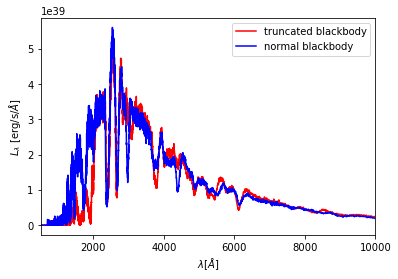

In [6]:
%matplotlib inline
plt.plot(mdl.runner.spectrum_virtual.wavelength,
         mdl.runner.spectrum_virtual.luminosity_density_lambda,
         color='red', label='truncated blackbody')
plt.plot(mdl_norm.runner.spectrum_virtual.wavelength,
         mdl_norm.runner.spectrum_virtual.luminosity_density_lambda,
         color='blue', label='normal blackbody')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()